In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd

import os
import glob

import seaborn as sns

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import json
import itertools

Facebook chat data has been downloaded in `inputs/messages_*.json`, and real names anonymized with `sed`.

In [3]:
# read in all chat data in JSON format
chatData = {}
for fin in glob.glob('inputs/message_*.json'):
    with open(fin) as f:
        data = f.read()
        # for the first json file, chatData is empty -- update the dictionary
        if 'messages' not in chatData:
            chatData.update(json.loads(data))
        # after the first, 'messages' exists and we don't want to overwrite it -- so extend the dictionary
        else:
            chatData['messages'].extend(json.loads(data)['messages'])

# one key in the JSON is 'participants', which is a list of dictionaries with key 'name'
persons = [p['name'] for p in chatData['participants']]

# the other key in the JSON is 'messages', which is a list of dictionaries like: 
"""    
{"sender_name": "D",
 "timestamp_ms": 1578769599245,
 "content": "10s of thousands of messages",
 "type": "Generic"
},"""

# create a DataFrame of all messages
df = pd.DataFrame(chatData['messages'], columns = ['sender_name', 'timestamp_ms', 'content'])

# giphy or photo messages have no 'content' are dropped
df = df[df.content.notnull()]

In [4]:
# define a function to tokenize all messages into words; drop "stop" words like "the", "a", etc

import nltk

sr = nltk.corpus.stopwords.words('english')

def clean_tokenize(df, speaker = 'all'):
    messages = df['content'].tolist() if speaker is 'all' else df[df.sender_name == speaker]['content'].tolist()
    tokens = [str(t).lower().split() for t in messages] # tokens[message][word in message]
    tokens = list(itertools.chain.from_iterable(tokens)) # flatten: tokens[word]
    # one speaker used an unusual but regular grammar error; clean this
    if speaker == 'C':
        for i in range(len(tokens)):
            if tokens[i].startswith('.') and not tokens[i].startswith('...'):
                tokens[i] = tokens[i][1:]
    # remove stop words and any other empty words
    clean_tokens = [t for t in tokens if t not in sr and t != 'nan']
    return clean_tokens

In [5]:
# create a dictionary of word tokens for each speaker, and all speakers together
tokensBySpeaker = { p : clean_tokenize(df, speaker = p) for p in persons }
tokensBySpeaker['all'] = [t for p in tokensBySpeaker for t in tokensBySpeaker[p]]

In [7]:
# lemmatize all tokens -- remove ending from words
from nltk.corpus import wordnet as wnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'): return wnet.ADJ
    elif treebank_tag.startswith('V'): return wnet.VERB
    elif treebank_tag.startswith('N'): return wnet.NOUN
    elif treebank_tag.startswith('R'): return wnet.ADV
    else: return nltk.wordnet.NOUN

lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
lemmatized_tokens = { p : [lemmatizer.lemmatize(t, pos = get_wordnet_pos(t))
                      for t in tokensBySpeaker[p]]
                      for p in tokensBySpeaker }

# Some analysis!

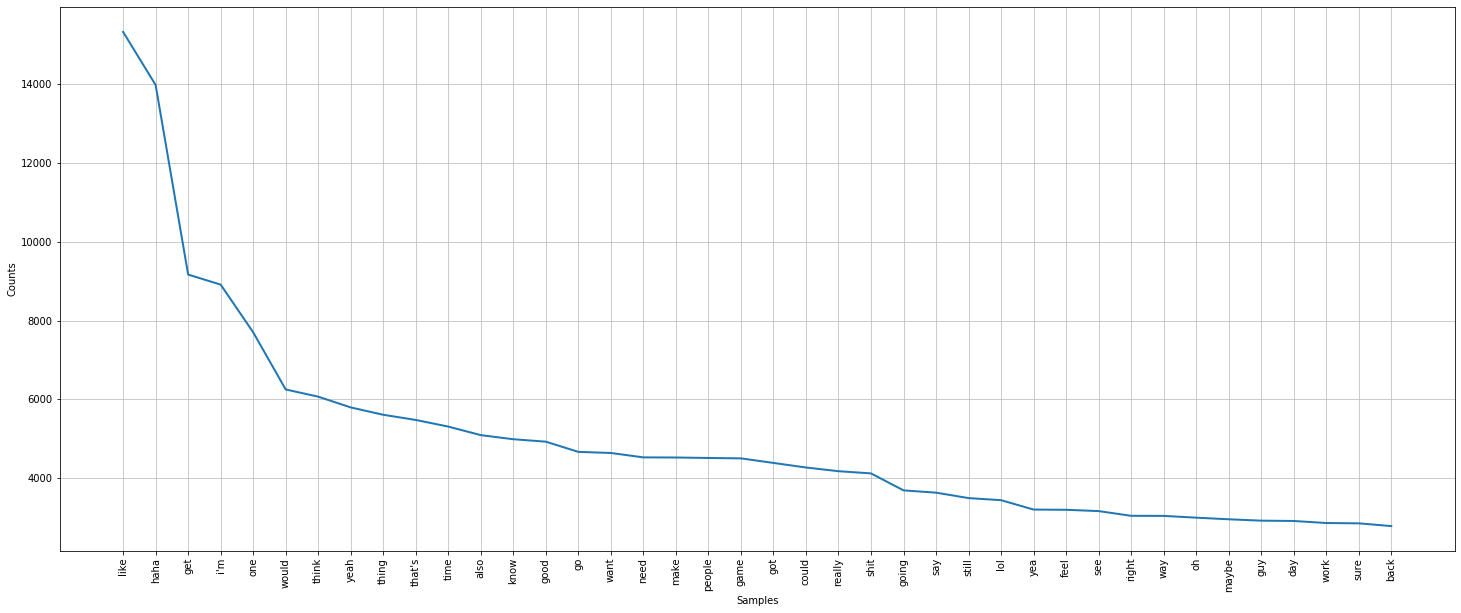

In [8]:
# What words were used the most frequently, overall?
freq = nltk.FreqDist(lemmatized_tokens['all'])
plt.figure(figsize = (25, 10))
fig = freq.plot(40, cumulative = False)

# Folks were interested in their individual word usage, so here they are!

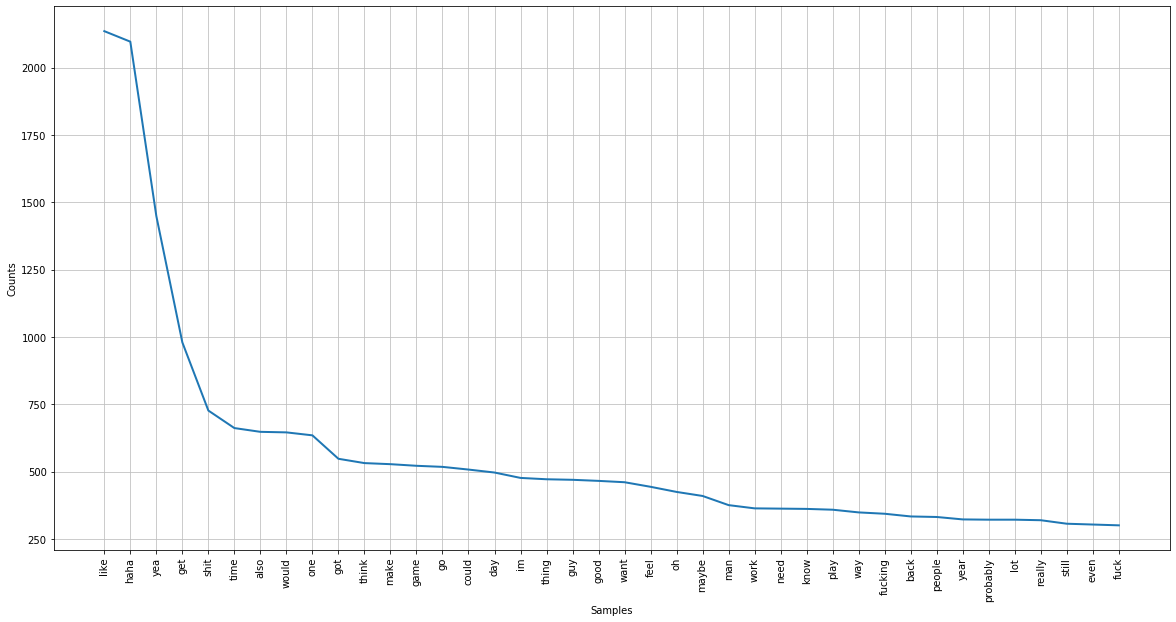

In [9]:
freq = nltk.FreqDist(lemmatized_tokens['B'])
plt.figure(figsize = (20, 10))
freq.plot(40, cumulative = False)

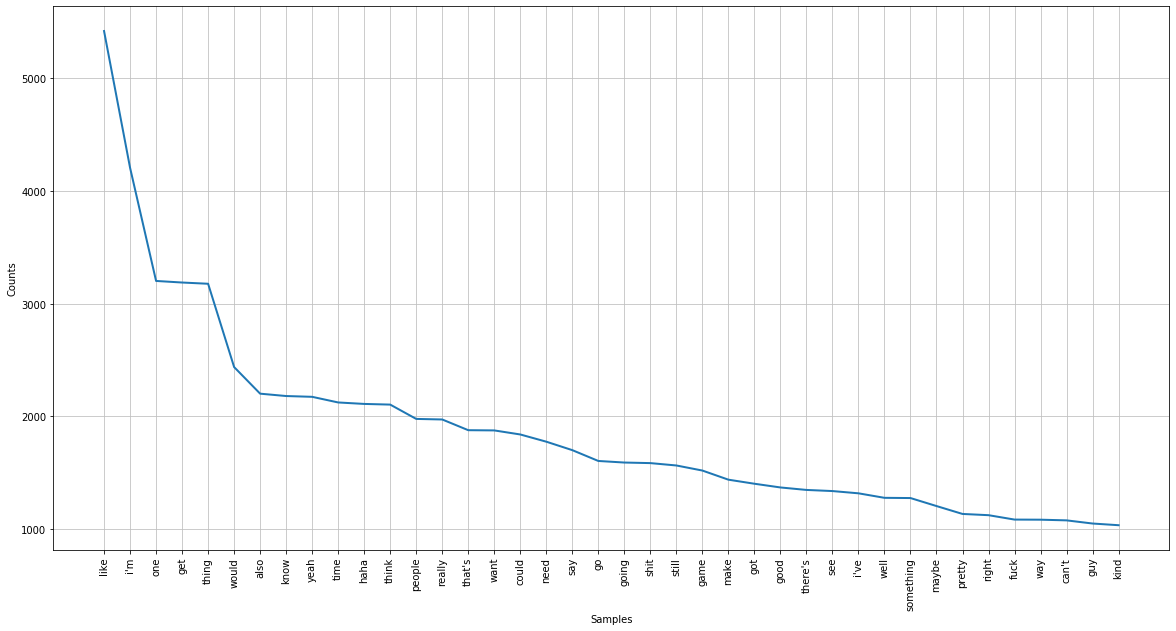

In [10]:
freq = nltk.FreqDist(lemmatized_tokens['C'])
plt.figure(figsize = (20, 10))
freq.plot(40, cumulative = False)

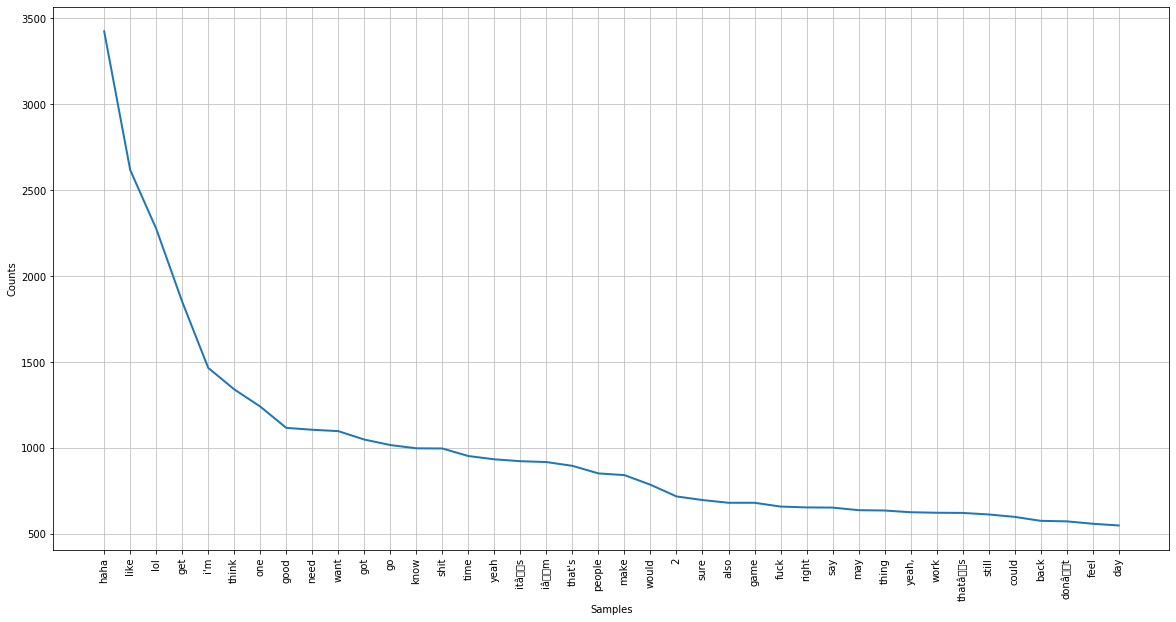

In [11]:
freq = nltk.FreqDist(lemmatized_tokens['D'])
plt.figure(figsize = (20, 10))
freq.plot(40, cumulative = False)

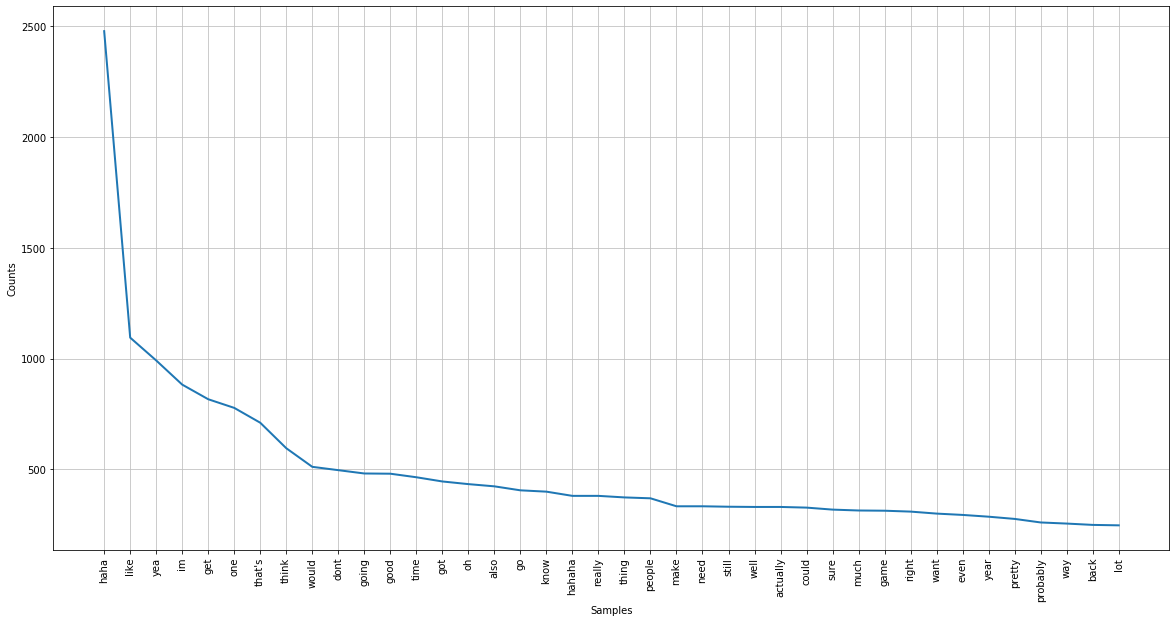

In [12]:
freq = nltk.FreqDist(lemmatized_tokens['E'])
plt.figure(figsize = (20, 10))
freq.plot(40, cumulative = False)

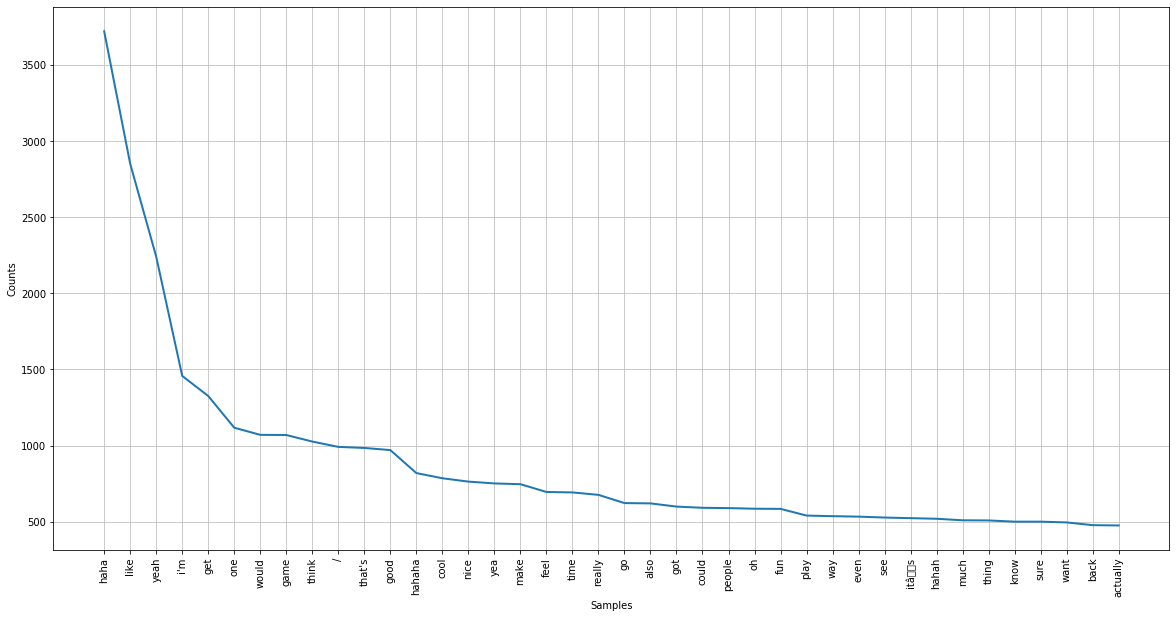

In [13]:
freq = nltk.FreqDist(lemmatized_tokens['F'])
plt.figure(figsize = (20, 10))
freq.plot(40, cumulative = False)

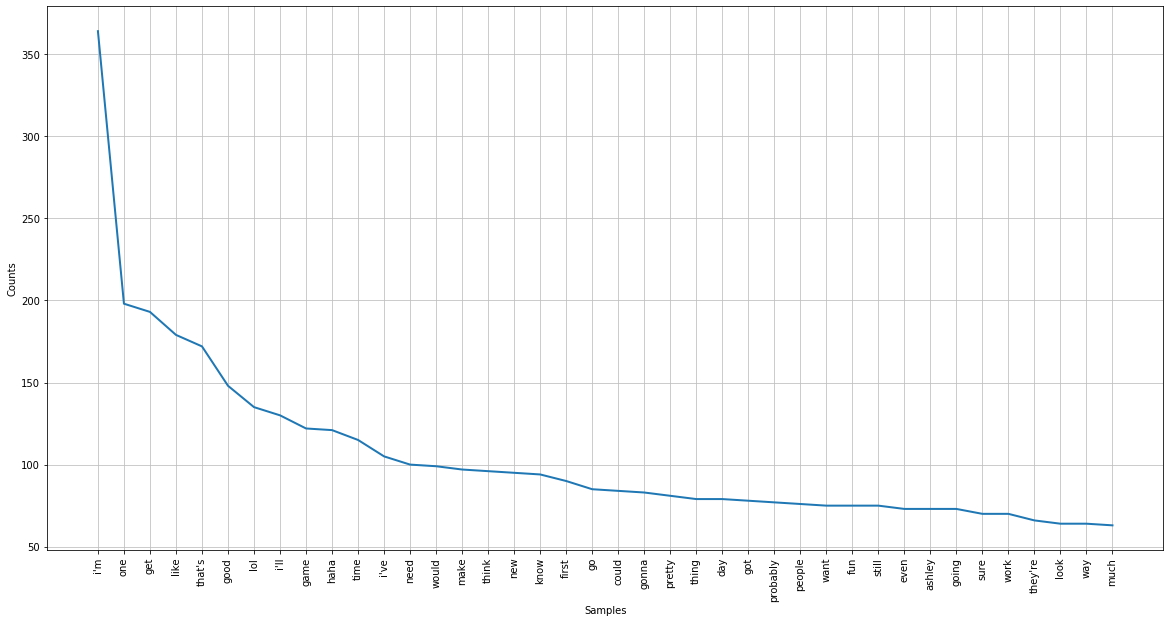

In [14]:
freq = nltk.FreqDist(lemmatized_tokens['G'])
plt.figure(figsize = (20, 10))
freq.plot(40, cumulative = False)

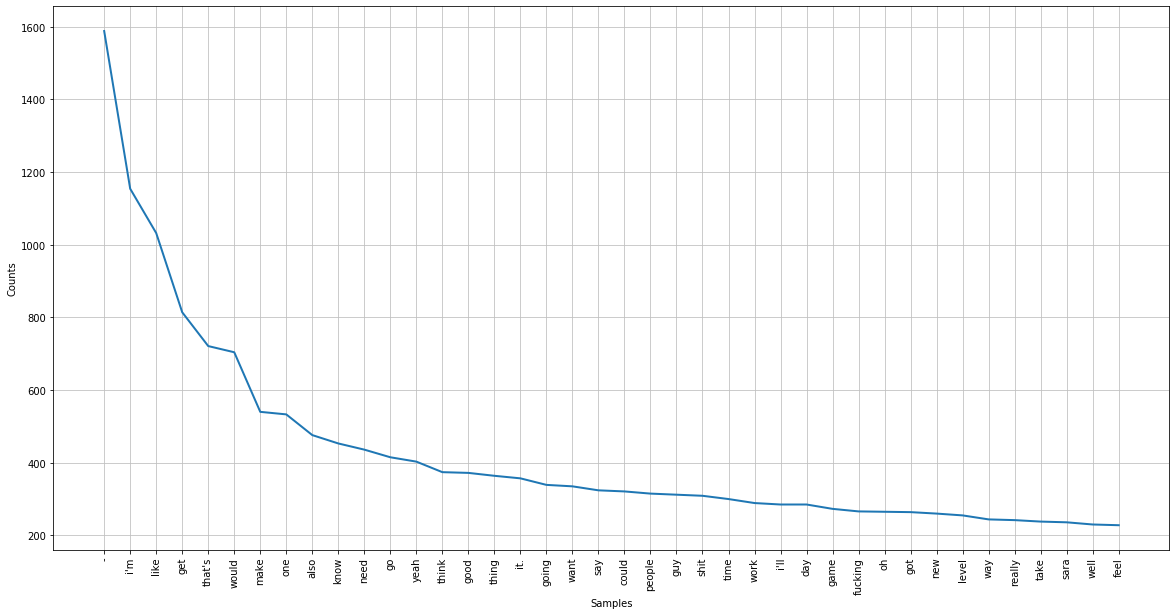

In [17]:
freq = nltk.FreqDist(lemmatized_tokens['H'])
plt.figure(figsize = (20, 10))
freq.plot(40, cumulative = False)

In [19]:
# Who's the toughest to read?
from readability import Readability

gradeLevels = []

for p in persons:
    print('Working on person:', p)
    r = Readability(". ".join(df[df.sender_name == p]['content'].tolist()))
    fk = r.flesch_kincaid()
    gradeLevels.append(fk.score)

Working on person: A
Working on person: B
Working on person: C
Working on person: D
Working on person: E
Working on person: F
Working on person: G
Working on person: H
Working on person: I


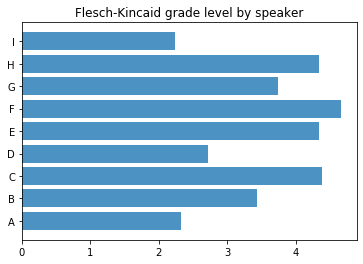

In [20]:
plot = plt.barh(persons, gradeLevels,
                align = 'center',
                alpha = 0.8,
                edgecolor = 'none',
                linewidth = 0,
                tick_label = persons)
plt.title('Flesch-Kincaid grade level by speaker')
plt.show()

In [27]:
# What times were speakers active?
import time

def parseTimes(person):
    epochTimes = [m['timestamp_ms'] for m in chatData['messages'] if m['sender_name'] == person]
    localTimes = [time.strftime('%u %H %M', time.localtime(m/1000.0)) for m in epochTimes]

    hour = [float(m.split()[1]) + float(m.split()[2])/60.0 for m in localTimes]
    day  = [int(m.split()[0]) for m in localTimes]
    return pd.DataFrame({'hour' : hour, 'day' : day})

messageTimes = { p : parseTimes(p) for p in persons }

In [28]:
palette = {}
for i, p in enumerate(persons):
    palette[p] = sns.color_palette()[i]

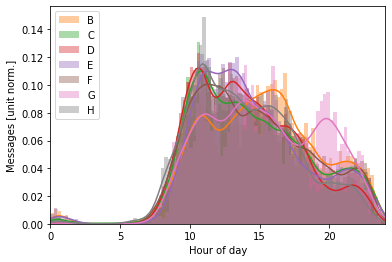

<Figure size 2160x1440 with 0 Axes>

In [23]:
for p in persons:
    if p == 'A' or p == 'I': continue
    ax = sns.distplot(messageTimes[p]['hour'], bins = 24 * 4, kde = True, color = palette[p], label = p)
plt.legend()
plt.xlabel('Hour of day')
plt.ylabel('Messages [unit norm.]')
plt.xlim(0, 24)
plt.figure(figsize=(30,20))
#ax.set(yscale = 'log')
plt.show()

In [29]:
messageTimes['B']['day'].head()

0    2
1    2
2    1
3    1
4    1
Name: day, dtype: int64

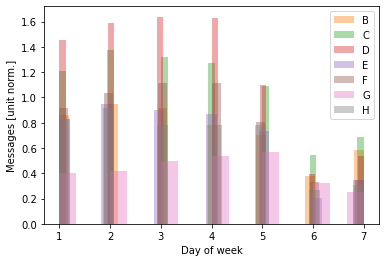

<Figure size 2160x1440 with 0 Axes>

In [46]:
for p in persons:
    if p == 'A' or p == 'I': continue
    ax = sns.distplot(messageTimes[p]['day'], kde = False, norm_hist = True, color = palette[p], label = p)
plt.legend()
plt.xlabel('Day of week')
plt.ylabel('Messages [unit norm.]')
#plt.xlim(1, 8)
plt.figure(figsize=(30,20))
#ax.set(yscale = 'log')
plt.show()